In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from healpy.newvisufunc import projview
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
from dipole import dipole_map, spherical_to_cartesian
import tools

$ X = [A^T C^{-1} A]^{-1} [A^T C^{-1} Y ] $

In [3]:
def lstsq(Y, A, Cinv):
    """
    Return the least-squares solution to a linear matrix equation,
    given data Y, design matrix A, and inverse covariance Cinv.
    """
    a = A.T @ Cinv @ A
    b = A.T @ Cinv @ Y
    res = np.linalg.lstsq(a, b, rcond=None)
    return res[0]

### $Y$ : QUaia raw counts

In [4]:
mapdir = '/scratch/aew492/quasars/catalogs'
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
G = 20.5
tab_quaia = Table.read(os.path.join(mapdir, f'quaia_G{G}.fits'), format='fits')
pix_idx = hp.ang2pix(NSIDE, tab_quaia['ra'], tab_quaia['dec'], lonlat=True)
map_quaia = np.bincount(pix_idx, minlength=NPIX)

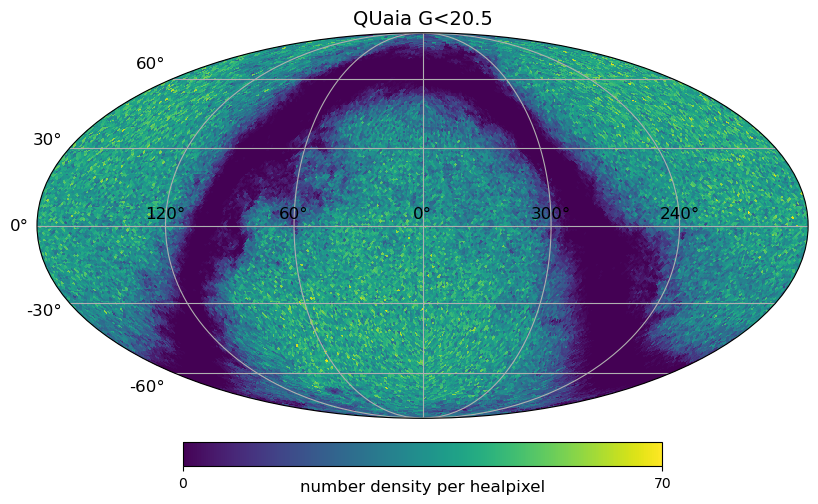

In [5]:
projview(map_quaia, title=f'QUaia G<{G}', unit='number density per healpixel',
         projection_type='mollweide', graticule=True, graticule_labels=True)

### $A$ : design matrix : selection function * expected dipole (CMB)

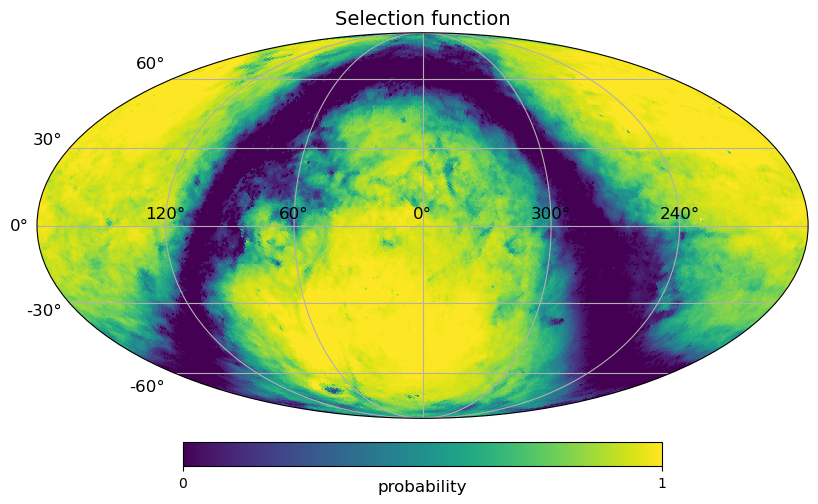

In [6]:
selfunc = tools.flatten_map(Table.read(
    f'/scratch/aew492/quasars/maps/selection_function_NSIDE{NSIDE}_G{G}.fits', format='fits'))
projview(selfunc, title='Selection function', unit='probability',
        graticule=True, graticule_labels=True)

In [7]:
# CMB dipole
cmb_dipamp = 0.007
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
print(cmb_dipdir.icrs)
# dipole amplitudes: zero mean for now
amps = np.array([0., *spherical_to_cartesian(r=cmb_dipamp,
                                             theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                             phi=cmb_dipdir.icrs.ra.rad)])
expected_map = dipole_map(amps, NSIDE) # match NSIDE with QUaia map

<SkyCoord (ICRS): (ra, dec) in deg
    (167.78661173, -7.14538872)>


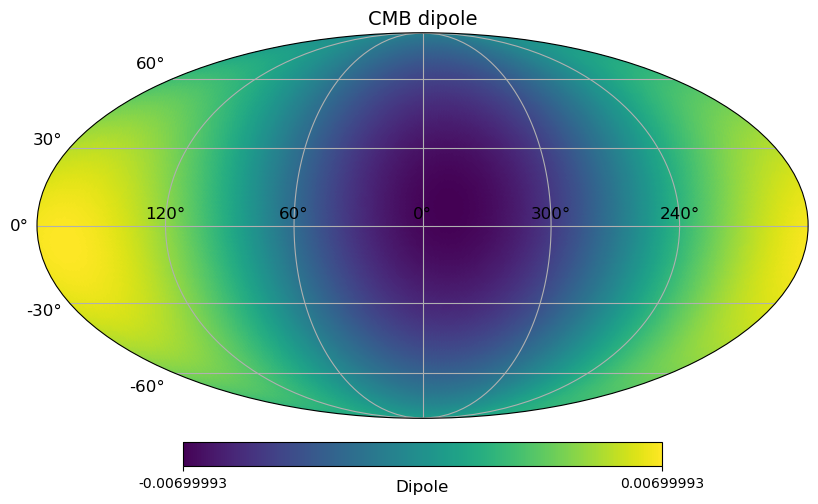

In [8]:
projview(expected_map, projection_type='mollweide', unit='Dipole',
         graticule=True, graticule_labels=True, title='CMB dipole')

In [9]:
# construct design matrix
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))  # [:,None] to make shapes agree

### $C^{-1}$ : weights = completeness

In [10]:
Cinv = np.diag(selfunc)

### perform the regression !

In [11]:
b, m = lstsq(map_quaia, A, Cinv)
b, m

(41.06267705322663, 64.79480768514367)

In [12]:
m/b # --> gives us the dipole amplitude !

1.5779489389148877

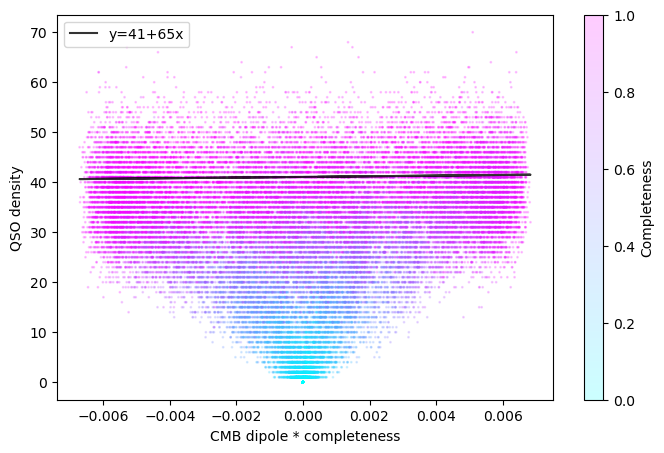

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
s = ax.scatter(A[:,1], map_quaia, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
ax.plot(A[:,1], b+m*A[:,1], color='k', alpha=0.8, label=f'y={b:.0f}+{m:.0f}x', zorder=100)
ax.set_xlabel('CMB dipole * completeness')
ax.set_ylabel('QSO density')
# ax.set_title('Dipole fit to QUaia catalog')
ax.legend()
fig.colorbar(s, label='Completeness')

### check that trivial cases match np.polyfit result

#### QUaia / completeness; no weights

In [14]:
# polyfit
map_quaia_expected = map_quaia / selfunc
idx_to_fit = np.where(~np.isnan(map_quaia_expected))
print(len(idx_to_fit[0])/len(map_quaia_expected))
mp, bp = np.polyfit(expected_map[idx_to_fit], map_quaia_expected[idx_to_fit], 1)
bp, mp

0.8718465169270834


/state/partition1/job-35377798/ipykernel_554237/2994900404.py:2: RuntimeWarning: invalid value encountered in divide
  map_quaia_expected = map_quaia / selfunc


(40.34242278063612, 93.22629854390141)

In [15]:
# construct matrices
Y = map_quaia_expected[idx_to_fit]
A = np.column_stack((np.ones_like(Y), expected_map[idx_to_fit]))
Cinv = np.identity(len(Y))

In [16]:
lstsq(Y, A, Cinv)

array([40.34242278, 93.22629854])

#### QUaia / completeness; weight by completeness

In [17]:
# polyfit
map_quaia_expected = map_quaia / selfunc
idx_to_fit = np.where(~np.isnan(map_quaia_expected))
print(len(idx_to_fit[0])/len(map_quaia_expected))
mp, bp = np.polyfit(expected_map[idx_to_fit], map_quaia_expected[idx_to_fit], 1, w=selfunc[idx_to_fit])
bp, mp

0.8718465169270834


/state/partition1/job-35377798/ipykernel_554237/3632935123.py:2: RuntimeWarning: invalid value encountered in divide
  map_quaia_expected = map_quaia / selfunc


(41.01584172776771, 67.05537472412634)

In [18]:
# construct matrices
Y = map_quaia_expected[idx_to_fit]
A = np.column_stack((np.ones_like(Y), expected_map[idx_to_fit]))
Cinv = np.diag(selfunc[idx_to_fit]**2)

In [19]:
lstsq(Y, A, Cinv)

array([41.01584173, 67.05537472])